# CEO-Request Challenge

## 1. Sorun Tanımının Özeti

❓ **Olist kârını nasıl artırabilir?** ❓

### P&L Kuralları

#### Revenues  (Gelirler )
**Sales fees:** Olist, teslim edilen her order’ın ürün fiyatı üzerinden (freight hariç) **%10 pay** alır.  
**Subscription fees:** Olist, seller başına ayda **80 BRL** ücret alır.

#### Costs (Maliyetler)
Kötü review’lara (<= 3 stars) sahip orders için _tahmini_ **reputation costs**  

💡 Uzun vadede kötü customer experience iş açısından sonuçlara yol açar: düşük tekrar satın alma oranı, anında customer support maliyeti, refunds veya olumsuz word of mouth iletişimi. Her kötü review için parasal bir cost varsayımı yapıyoruz:

```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist'in total cumulated IT Costs değeri, platforma şimdiye kadar katılmış toplam seller sayısının karekökü ile, şimdiye kadar satılmış toplam birikimli item sayısının karekökü oranında ölçeklenir.

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  

Olist'in data team’i bize bu scaling parameter’ları için şu değerleri verdi:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Yönetilen seller sayısı da, sales transaction sayısı da IT systems için maliyetlidir.
💡 Ancak karekök kullanımı scale-effects’i gösterir: IT-system’ler büyüdükçe daha verimli olma eğilimindedir.
💡 Alpha > Beta olması, Olist’in çok item satan az sayıda seller ile çalıştığında, bunun tersi senaryoya göre daha düşük IT Cost’a sahip olduğu anlamına gelir.

1000 sellers ve toplam 100 items satışıyla toplam IT cost 109,624 BRL olur

100 sellers ve toplam 1000 items satışıyla toplam IT cost 62,507 BRL olur

Son olarak, IT department size marketplace’in kuruluşundan bu yana birikmiş IT costs toplamının 500,000 BRL olduğunu da iletti.

Şimdi, bu IT cost formülünü biraz daha iyi anlamak için bir simulation çalıştıralım. Kod üzerinde zaman harcamanıza gerek yok, sadece ortaya çıkan chart’lara bakın.

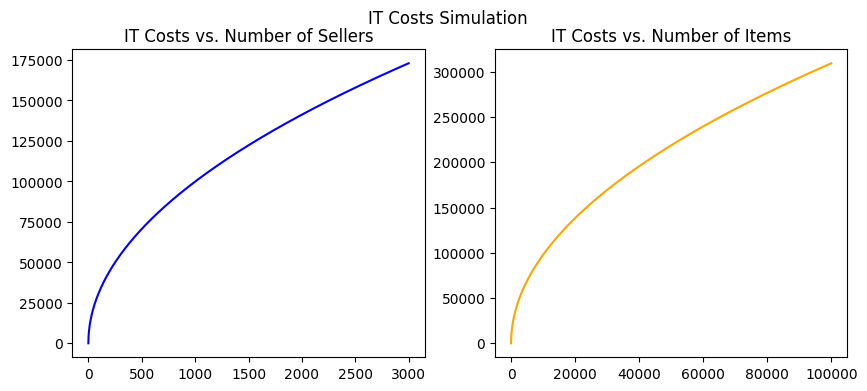

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

alpha = 3157.27
beta = 978.23

x_sellers = np.arange(3_000)
y_it_costs_sellers = alpha * x_sellers ** 0.5

x_items = np.arange(100_000)
y_it_costs_items = beta * x_items ** 0.5

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_sellers, y_it_costs_sellers, label='IT costs per seller', color='blue')
plt.title('IT Costs vs. Number of Sellers')
plt.subplot(1, 2, 2)
plt.plot(x_items, y_it_costs_items, label='IT costs per item', color='orange')
plt.title('IT Costs vs. Number of Items')
plt.suptitle('IT Costs Simulation');

### Key Findings, so far

- `wait_time`, düşük review_score’ların arkasındaki en önemli faktördür.  
- `wait_time`, seller’ın `delay_to_carrier` süresi + `carrier_delivery_time` toplamından oluşur.  
- Carrier’ın delivery time’ı Olist’in doğrudan kontrolünde olmadığı için, bunu iyileştirmek hızlı kazanım sağlayacak bir öneri değildir.  
- Buna karşılık, daha iyi bir `seller` seçimi `delay_to_carrier` değerini olumlu şekilde etkileyebilir ve Olist üzerindeki kötü `review_scores` sayısını azaltabilir.  
- Kötü review’lardaki yorumlar, bazılarının seller’dan veya bizzat üründen kaynaklandığını göstermiştir.

💡 Aşağıdaki bölüm 2’deki guided seller analysis ile başlamanızı öneririz.

💪 Ancak bölüm 3 ile başka hipotezleri araştırmakta özgürsünüz.

## 2. Olist, performansları düşük satıcıları pazarından çıkarmalı mı? 🕵🏻
*(önerilen)*

Olist’in marketplace’inden en kötü seller’ları çıkarmanın etkisini analiz etmek için bir **what-if analysis** yapacağız.

👉 **Olist bu seller’ları en baştan hiç kabul etmemiş olsaydı ne olurdu?**  

*(Gerçekte, kimin iyi seller olduğunu önceden bilmek zordur, ancak bu yaklaşımla başlayıp daha sonra iterasyon yapacağız.)*


### 2.1 Veri Hazırlama

Her bir `seller_id` için, başlangıçtan itibaren kümülatif olarak hesaplayın:
- seller’ın getirdiği `revenues`
- seller’ın kötü review’larına bağlı `review_costs`
- ortaya çıkan `profits` (revenues - costs)

👉 İhtiyacınız olan DataFrame’i oluşturmak için adım adım bir strateji yazın.

⚠️ **Sıfırdan başlamayın, mevcut package’ınızı güncelleyin!** 😉

**Çözüm, notebook’a yeni kod yazmakta değil — `.py` dosyalarınızdaki kodu değiştirmektedir.**

`olist` package’ınız içindeki `Seller` class’ından başlayarak:

`get_training_data` method’unu düzenleyin; döndürdüğü DataFrame şu alanları içermeli:
- `revenues`: subscription + sales fees toplamı  
- `cost_of_reviews`: kötü review’lara bağlı toplam cost  
- `profits`: `revenues` - `cost_of_reviews`

`cost_of_reviews` için önce başka bir method’u değiştirmeniz gerekecek. Bununla ilgili olan method hangisi?

In [18]:
from olist.seller import Seller
sellers = Seller().get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,sales_fee,subscription_fee,revenues
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,21.870,320.0,341.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,1170.307,1120.0,2290.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,15.800,0.0,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99,7.999,0.0,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99,16.799,0.0,16.799


In [24]:
sellers = Seller().get_training_data()
sellers[['revenues','cost_of_reviews','profits']].head()

,revenues,cost_of_reviews,profits
0,341.870,140.0,201.870
1,2290.307,240.0,2050.307
2,15.800,0.0,15.800
3,7.999,0.0,7.999
4,16.799,100.0,-83.201


### 2.2 IT Maliyetleri Hariç Varsayım Analizi

👉 Gerçek analizi yapma zamanı. İlk olarak bunu IT costs **dahil etmeden** gerçekleştireceğiz.

Adımlarımız:  

1️⃣ Sellers verisini load edin ve profits değerine göre azalan şekilde sıralayın.

2️⃣ Cumulative değerleri hesaplayın:
   - Her satır için cumulative revenues hesaplayın.
   - Her satır için cumulative profits hesaplayın.
   - Her satır için cumulative items sold hesaplayın.

   Pandas ile cumulative sum nasıl hesaplanır, araştırın.

3️⃣ Sonuçlarınızı plot edin ve analiz edin. Pandas’ın `.plot()` method’unu kullanın.

4️⃣ Profits’e göre tutulması gereken optimum seller sayısını belirleyin. (İpucu: `np.argmax` araştırın). Bu kararın etkisi ne olurdu:
   - Net profit (IT costs dahil etmediğimiz için IT costs öncesi)?
   - Total revenues?
   - Seller sayısı?
   - Satılan item sayısı?

In [50]:
order_profit_df = sellers.sort_values("profits",ascending=False).reset_index(drop=True).copy()

order_profit_df.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score,cost_of_reviews,sales_fee,subscription_fee,revenues,profits
0,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,358,410,1.145251,222776.05,0.561798,0.095506,4.132022,5170.0,22277.605,960.0,23237.605,18067.605
1,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,336,340,1.011905,176431.87,0.629851,0.101493,4.214925,4700.0,17643.187,1680.0,19323.187,14623.187
2,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,585,586,1.001709,194042.03,0.676420,0.086059,4.339071,6510.0,19404.203,1600.0,21004.203,14494.203
3,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,166,175,1.054217,79284.55,0.692771,0.066265,4.421687,1520.0,7928.455,880.0,8808.455,7288.455
4,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,23.0,521,542,1.040307,128111.19,0.629126,0.112621,4.194175,7500.0,12811.119,1840.0,14651.119,7151.119


In [86]:
order_profit_df["cum_revenues"] = order_profit_df['revenues'].cumsum()
order_profit_df["cum_profits"] = order_profit_df['profits'].cumsum()
order_profit_df["cum_items"] = order_profit_df['quantity'].cumsum()
order_profit_df["cum_sellers"] = np.arange(1, len(order_profit_df) + 1)

order_profit_df.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,...,review_score,cost_of_reviews,sales_fee,subscription_fee,revenues,profits,cum_revenues,cum_profits,cum_items,cum_sellers
0,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,358,410,...,4.132022,5170.0,22277.605,960.0,23237.605,18067.605,23237.605,18067.605,410,1
1,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,336,340,...,4.214925,4700.0,17643.187,1680.0,19323.187,14623.187,42560.792,32690.792,750,2
2,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,585,586,...,4.339071,6510.0,19404.203,1600.0,21004.203,14494.203,63564.995,47184.995,1336,3
3,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,166,175,...,4.421687,1520.0,7928.455,880.0,8808.455,7288.455,72373.450,54473.450,1511,4
4,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,23.0,521,542,...,4.194175,7500.0,12811.119,1840.0,14651.119,7151.119,87024.569,61624.569,2053,5


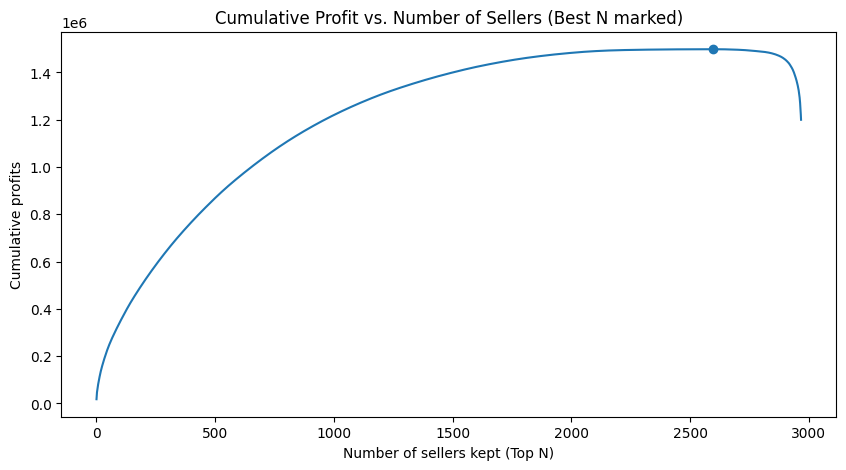

Best N: 2598 , Best cumulative profit: 1497961.04


In [87]:
best_idx = order_profit_df["cum_profits"].values.argmax()
best_n = order_profit_df.loc[best_idx, "cum_sellers"]
best_profit = order_profit_df.loc[best_idx, "cum_profits"]

plt.figure(figsize=(10,5))
plt.plot(order_profit_df["cum_sellers"], order_profit_df["cum_profits"])
plt.scatter([best_n], [best_profit])
plt.title("Cumulative Profit vs. Number of Sellers (Best N marked)")
plt.xlabel("Number of sellers kept (Top N)")
plt.ylabel("Cumulative profits")
plt.show()

print("Best N:", best_n, ", Best cumulative profit:", round(best_profit,2))


In [49]:
order_profit_df[order_profit_df['cum_sellers']==best_n]

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,...,review_score,cost_of_reviews,sales_fee,subscription_fee,revenues,profits,cum_revenues,cum_profits,cum_items,cum_sellers
2597,e819bcfade7b5d88a27325eb6cfd62c5,guarulhos,SP,0.0,8.968804,2018-07-20 14:45:19,2018-08-20 23:49:16,1.0,5,11,...,4.2,100.0,20.29,80.0,100.29,0.29,2336541.039,1497961.039,67719,2598


### 2.3 IT maliyetleri ile varsayımsal analiz (İsteğe bağlı)

👉 Bu kez IT costs dahil edilerek gerçek analizi yapma zamanı.

Adımlarımız şunlar:  

1️⃣ İki parametreye göre IT costs hesaplayan bir function yazın: seller sayısı ve item sayısı. Temelde matematiksel formülü Python kullanarak yazmanız yeterli.

2️⃣ Sellers verisini load edin ve (IT costs öncesi) kârlarına göre azalan şekilde sıralayın.

3️⃣ Cumulative değerleri hesaplayın (önceki kodu yeniden kullanın):
   - Her satır için cumulative revenues hesaplayın.
   - Her satır için cumulative profits hesaplayın.
   - Her satır için toplam satılan item miktarının cumulative değerini hesaplayın.  

4️⃣ IT costs etkisini hesaplayın:
   - 1️⃣. adımda yazdığınız function’ı kullanarak her satır için cumulative IT cost ekleyin.
   - IT costs sonrası net profit’i hesaplayın.

5️⃣ Sonuçlarınızı plot edin ve analiz edin.

6️⃣ Bu kez IT costs sonrası kârları baz alarak tutulması gereken optimum seller sayısını belirleyin. Bu kararın etkisi ne olurdu:
   - IT costs sonrası net profit?
   - IT costs öncesi net profit?
   - IT costs?
   - Total revenues?
   - Seller sayısı?
   - Satılan item sayısı?

Analizinizde IT costs ne kadar önemliydi?


In [53]:
def it_cost(n_sellers, n_items):
    return alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)


In [77]:
cols = [
    "cum_sellers", "profits", "revenues", "quantity", "cum_items", "cum_it_cost", "cum_profits", "cum_revenues", 'cum_profits_after_it_cost'
]

df = sellers.sort_values('profits',ascending=False).reset_index(drop=True)
df['cum_revenues'] = df['revenues'].cumsum()
df['cum_profits'] = df['profits'].cumsum()
df['cum_items'] = df['quantity'].cumsum()
df['cum_sellers'] = np.arange(1, len(df)+1)
df['cum_it_cost'] = it_cost(n_sellers=df['cum_sellers'],n_items=df['cum_items'])
df['cum_profits_after_it_cost'] = df['cum_profits'] - df['cum_it_cost']

df[cols].head()


,cum_sellers,profits,revenues,quantity,cum_items,cum_it_cost,cum_profits,cum_revenues,cum_profits_after_it_cost
0,1,18067.605,23237.605,410,410,22964.917828,18067.605,23237.605,-4897.312828
1,2,14623.187,19323.187,340,750,31254.985925,32690.792,42560.792,1435.806075
2,3,14494.203,21004.203,586,1336,41224.163282,47184.995,63564.995,5960.831718
3,4,7288.455,8808.455,175,1511,44339.889079,54473.450,72373.450,10133.560921
4,5,7151.119,14651.119,542,2053,51383.513743,61624.569,87024.569,10241.055257


In [91]:
best_idx_it = df["cum_profits_after_it_cost"].values.argmax()
best_row_it = df.loc[best_idx_it, :]
best_row_it[["cum_sellers","cum_profits_after_it_cost","cum_profits","cum_it_cost","cum_revenues","cum_items"]]


cum_sellers                            2139
cum_profits_after_it_cost    1093618.722737
cum_profits                     1491818.838
cum_it_cost                   398200.115263
cum_revenues                    2314748.838
cum_items                             66456
Name: 2138, dtype: object

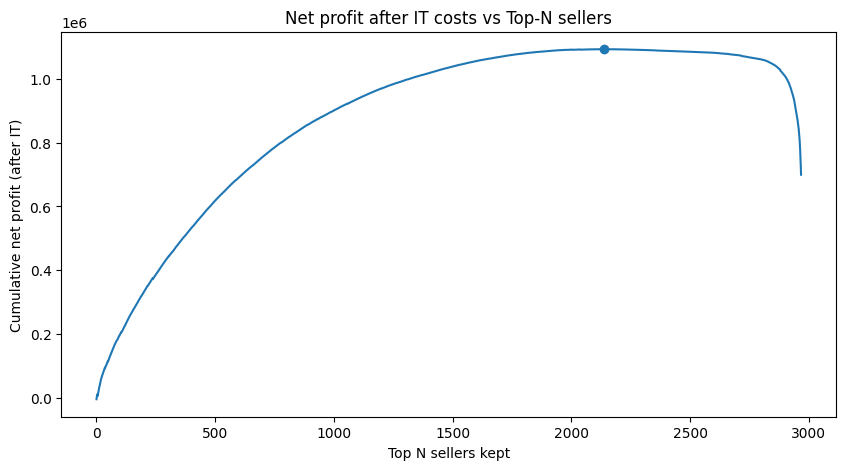

In [92]:
plt.figure(figsize=(10,5))
plt.plot(df["cum_sellers"], df["cum_profits_after_it_cost"])
plt.scatter([best_row_it["cum_sellers"]], [best_row_it["cum_profits_after_it_cost"]])
plt.xlabel("Top N sellers kept")
plt.ylabel("Cumulative net profit (after IT)")
plt.title("Net profit after IT costs vs Top-N sellers")
plt.show()


## CEO Summary (What-If: düşük performanslı seller’ları çıkarmak)

**Amaç:** Olist kârını artırmak için “en düşük performanslı seller’ları” platformdan çıkarmanın etkisini ölçmek.

### P&L Tanımı (seller bazında)
- **Revenues** = %10 × `sales` + 80 BRL × `months_on_olist`
- **Costs (reputation)** = `cost_of_reviews` (1★=100, 2★=50, 3★=40; 4–5★=0)
- **Profits** = `revenues` − `cost_of_reviews`

### Yöntem (What-If)
- Seller’ları `profits` değerine göre **azalan** sıraladık.
- “Top-N seller tutarsak” senaryosunu kümülatif olarak simüle ettik ve aşağıdaki metrikleri hesapladık:
  - `cum_revenues`, `cum_profits`, `cum_items`, `cum_sellers`

---

## Sonuç 1 — IT maliyeti hariç (2.2)
- **Optimum Top-N (IT yok):** **2,598 seller**
- **Kümülatif kâr (IT öncesi):** **1,497,961.04 BRL**

> Bu noktadan sonra daha fazla seller eklemek toplam kârı düşürüyor (marjinal seller’lar negatif / düşük katkı).

---

## Sonuç 2 — IT maliyeti dahil (2.3)
IT cost fonksiyonu:
\[
IT\_cost = \alpha \sqrt{n\_sellers} + \beta \sqrt{n\_items}
\quad (\alpha=3157.27,\ \beta=978.23)
\]

- **Optimum Top-N (IT dahil):** **2,139 seller**
- Bu noktada:
  - **IT öncesi kâr (`cum_profits`):** **1,491,818.839 BRL**
  - **IT cost (`cum_it_cost`):** **398,200.115 BRL**
  - **IT sonrası net kâr:** **1,093,618.723 BRL**
  - **Total revenues:** **2,314,748.839 BRL**
  - **Items sold:** **66,456**

> IT maliyeti eklendiğinde optimum seller sayısı **2,598 → 2,139** düşüyor.  
> Yani IT, net kârı azaltmakla kalmıyor; “kaç seller tutmalıyız?” kararını da değiştiriyor.

---

## Öneri
- IT maliyeti dikkate alındığında, kârlılığı maksimize etmek için **Top 2,139 seller** seviyesinde kalmak en iyi görünüyor.
- Bu bulguyu operasyonel politikaya çevirmek için:
  - yeni seller onboarding’de minimum kalite eşiği / probation,
  - düşük performanslı seller’lar için iyileştirme planı veya kademeli çıkış
  önerilir.


## 3. Diğer Yaklaşımları Araştırın 🕵️
*(isteğe bağlı)*

- Olist, en kötü performans gösteren ürünleri/kategorileri pazarından tamamen kaldırmalı mı?
- Olist, birkaç aylık balayı döneminden sonra, sadece sürekli olarak düşük performans gösteren satıcıları kaldırmalı mı?
- Olist, satıcılardan ürün listelerine belirli bilgileri eklemelerini zorunlu kılmalı mı?
- Olist, günün belirli saatlerinde müşterilerden satın alma onayı istemeli mi?
- Olist, gecikmeleri önlemek için belirli eyaletler arasındaki satıcı/müşteri çiftlerini kısıtlamalı mı?
- Olist, bazı maliyet varsayımları önerilerek yeni satıcılar kazanmalı mı?
- ...

## Sıra Sende!

🧺 Bu defteri düzenli tutun! 

🗣 📊 Bu `Communicate`  ünitesinin sonunda, en sevdiğiniz TA'ya görüşlerinizi sunacaksınız 💪